<a href="https://colab.research.google.com/github/KozukiO/97452023_70432023/blob/main/Ayeyi_Mills_Amenoracking_Amenreynolds_97452023_70432023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Recurrent Neural Network

Classifying names by country of origin.

Based on: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

## Preparing Data

Import Statements

In [70]:
# Imports
import unicodedata
import re
import string
import glob
import os
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

Mount Google Drive

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Initiate All Letters

In [72]:
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

Remove All Special Characters

Method that Changes Special Characters to Ascii

In [73]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s, all_letters):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


Importing Training Datasets

In [74]:
pidgin = pd.read_csv('/content/drive/MyDrive/data/pcm/train.tsv',sep='\t')
hausa = pd.read_csv('/content/drive/MyDrive/data/hau/train.tsv',sep='\t')
ibo = pd.read_csv('/content/drive/MyDrive/data/ibo/train.tsv',sep='\t')

Importing Test Sets

In [75]:
pidgin_t = pd.read_csv('/content/drive/MyDrive/data/pcm/test.tsv',sep='\t')
hausa_t = pd.read_csv('/content/drive/MyDrive/data/hau/test.tsv',sep='\t')
ibo_t = pd.read_csv('/content/drive/MyDrive/data/ibo/test.tsv',sep='\t')

Data Preprocessing

In [76]:
#Removing @user from Ibo and Hausa Language Tweets
ibo['tweet'] = ibo['tweet'].str.replace('@user', '')
hausa['tweet'] = hausa['tweet'].str.replace('@user', '')
pidgin['tweet'] = pidgin['tweet'].str.replace('@user', '')

#Removing Hyperlinks from ibo language
ibo['tweet'] = ibo['tweet'].apply(lambda x: re.sub(r'http\S+', '', x, flags=re.MULTILINE))
hausa['tweet'] = hausa['tweet'].apply(lambda x: re.sub(r'http\S+', '', x, flags=re.MULTILINE))
pidgin['tweet'] = pidgin['tweet'].apply(lambda x: re.sub(r'http\S+', '', x, flags=re.MULTILINE))


Initializing Categories

In [77]:
all_sentiments = ["positive","negative","neutral"]


Read data Method that puts data into training dictionary

In [78]:
def readData(data):
  #Initialize Categories
  language_lines = {
    "positive": [],
    "neutral": [],
    "negative": []
    }
    #For Loop to map each statement to its correct Sentiment
  for index, row in data.iterrows():
    if row['label'] == "positive":
      language_lines["positive"].append(row["tweet"].encode('ascii','ignore').decode("utf-8"))
    elif row['label'] == "negative":
      language_lines["negative"].append(row["tweet"].encode('ascii','ignore').decode("utf-8"))
    else:
      language_lines["neutral"].append(row["tweet"].encode('ascii','ignore').decode("utf-8"))
  #Return the Dictionary
  return language_lines

pidgin_train = readData(pidgin)
hausa_train = readData(hausa)
ibo_train = readData(ibo)


print("================= A look at Training Dictionary for Pidgin:")
print(pidgin_train)
print("================= A look at Training Dictionary for hausa:")
print(hausa_train)
print("================= A look at Training Dictionary for ibo:")
print(ibo_train)

================= A look at Training Dictionary for Pidgin:
{'positive': ['please ooo i am not hurt i am just reacting to a tweet i saw about soft men even saw people who have dished pain to the softest men i know waggling their tail there na wetin vex me i am good my women dey try ', 'baba na who dem give dey give thanks i don drop details tire make i smile like others na', 'e be like oooo baba just sabi too read wetin go commot and when e go read wetin no go commot too in go calm down jot am too', 'lmao this na just noodles na but which kain egusi you cook wey dog no go fit chop', 'the guy don go again catch this guy abegggggggggg e dey spoil your name na', 'ah e don happen owhich kind virus is this ffs how dem wan take trace all those people he must had contact with now ehn', 'dem no wan give us light o government no wan support our new lifestyle', 'lmao i swear e be like person wey dey argue with google', 'i opened ig live to see pheels and mastercraft then i heard egungun be caref

In [79]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(all_letters, letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
# Extra 1 dimension is batch size
def lineToTensor(line, n_letters, all_letters):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(all_letters, letter)] = 1
    return tensor

print("================ Letter to Index: ")
print(letterToIndex(ALL_LETTERS, "d"))

print("================= LineToTensor")
x = lineToTensor('Jones', N_LETTERS, ALL_LETTERS)
print(x)
print(x.shape)

================ Letter to Index: 
3
================= LineToTensor
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.,

## Creating Network

![picture](https://drive.google.com/uc?id=1tkt_c-yMbYxGhO-5iyL8UFiKyRlLu1IP)

In [80]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        #input2hidden
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)

        #input2output
        self.i2o = nn.Linear(input_size + hidden_size, output_size)

        self.ReLU = nn.ReLU()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.ReLU(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


## Training

In [81]:
def categoryFromOutput(output, all_sentiments):
    top_n, top_i = output.topk(1)
    sentiment_i = top_i[0].item()
    return all_sentiments[sentiment_i], sentiment_i


n = len(all_sentiments)
test_output = torch.rand(1,n)

print("=============== Output: ")
print(test_output)
print(test_output.shape)
print("=============== All Sentiments")
print(all_sentiments)
print("Category from Output")
print(categoryFromOutput(test_output, all_sentiments))

=============== Output: 
tensor([[0.9872, 0.7267, 0.3989]])
torch.Size([1, 3])
=============== All Sentiments
['positive', 'negative', 'neutral']
Category from Output
('positive', 0)


In [82]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(all_sentiment, language_lines, n_letters, all_letters):
    sentiment = randomChoice(all_sentiments)
    line = randomChoice(language_lines[sentiment])
    sentiment_tensor = torch.tensor([all_sentiments.index(sentiment)], dtype=torch.long)
    line_tensor = lineToTensor(line, n_letters, all_letters)
    return sentiment, line, sentiment_tensor, line_tensor

#Training Examples
#Pidgin
print("======== Some random Pidgin training examples")
for i in range(10):
    sentiment, line, category_tensor, line_tensor = (
        randomTrainingExample(all_sentiments, pidgin_train, N_LETTERS, ALL_LETTERS))
    print('Sentiment =', sentiment, '/ line =', line)
print()

#Hausa
print("======== Some random Hausa training examples")
for i in range(10):
    sentiment, line, category_tensor, line_tensor = (
        randomTrainingExample(all_sentiments, hausa_train, N_LETTERS, ALL_LETTERS))
    print('Sentiment =', sentiment, '/ line =', line)
print()

#Ibo 
print("======== Some random Pidgin training examples")
for i in range(10):
    sentiment, line, category_tensor, line_tensor = (
        randomTrainingExample(all_sentiments, ibo_train, N_LETTERS, ALL_LETTERS))
    print('Sentiment =', sentiment, '/ line =', line)

======== Some random Pidgin training examples
Sentiment = negative / line = abeg make una help me run this thing i have a cater on standby to cook some banging party rice na money we need epp us
Sentiment = neutral / line = kai fine boys like us we we no dey too look for women like that na dem dey rush us
Sentiment = positive / line = you na boss already wetin u wan learn again
Sentiment = positive / line = alamanjo do wetin god say make u do that k important na my account number first bank na d bankthank you as god use u amen
Sentiment = neutral / line = if dem born you for nigeria automatically life don dey ahead of if you come fall for poor family if you come be first born paddy take life jejena money dey make normal problem be like spiritual problem
Sentiment = negative / line = just negodu this one wey we dey na heaven how hell wan take be oh god have mercy on us
Sentiment = negative / line = uncle sola why u sef go dey like my sister lips
Sentiment = positive / line = as e dey ho

Defining Training Method

In [83]:
def train(category_tensor, line_tensor, hparams, rnn, criterion):
    hidden = rnn.initHidden()

    # https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html
    rnn.zero_grad()

    # Looping through characters
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-hparams["learning_rate"])

    # loss.item() is the loss value
    return output, loss.item()

In [84]:

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def run(n_iters, print_every, plot_every, hparams, rnn, criterion, 
        all_categories, category_lines, n_letters, all_letters):
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []

    start = time.time()

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = (
            randomTrainingExample(all_categories, category_lines, n_letters, all_letters))
        output, loss = train(category_tensor, line_tensor, hparams, rnn, criterion)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output, all_categories)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
    return all_losses

In [96]:
# Start Training
_n_iters = 100000
_print_every = 5000
_plot_every = 1000

_hparams = {}

# If you set this too high, it might explode. If too low, it might not learn
_hparams["learning_rate"] = 0.000005 

# Loss (negative log likelihood)
_criterion = nn.NLLLoss()


_n_hidden = 128
_n_categories = len(all_sentiments)
_RNN = RNN(N_LETTERS, _n_hidden, _n_categories)


Pidgin Training

In [116]:
PIDGIN_LOSSES = run(_n_iters, _print_every, _plot_every, _hparams, _RNN, _criterion, all_sentiments, pidgin_train, N_LETTERS, ALL_LETTERS)



500 5% (0m 8s) 0.0000 do small giveaway na just to celebrate the ferrari with us your loveable cupcakes na / neutral ✗ (positive)
1000 10% (0m 16s) -0.1858 balikis no sabi kiss omowumi don do abortions iya abiye sef never born even morenikeji never get partner ifelodun don break up wetin we never see for our street even excellent sef dey carryover courses / neutral ✓
1500 15% (0m 24s) -0.0967 you see my parents my first priority cos i am blessed and will be more successful god na me go make dem relax like they deserve i go buy my mother anything wey she need my papa ehh strong man day in day out god theres nothing impossible for you / neutral ✗ (positive)
2000 20% (0m 32s) 0.0000 you fine die you fine like ki lo de de you fine my mama dey jealous me you fine die come here / negative ✗ (positive)
2500 25% (0m 40s) -0.1285 ner take away u dey use in your home as plate / negative ✓
3000 30% (0m 49s) -0.0999 i said you will reach your destination in jesus name whether na bablawo whish abi 

Hausa Training

In [117]:
HAUSA_LOSSES = run(_n_iters, _print_every, _plot_every, _hparams, _RNN, _criterion, all_sentiments, hausa_train, N_LETTERS, ALL_LETTERS)


500 5% (0m 4s) -0.1390  Tunda yayan su suna kasashen waje mi zai dame su / neutral ✓
1000 10% (0m 8s) -0.1044  Allah ya tsayar haka bijahi Maulatii sayyada fadeemah alaihas salatu wassalam  / neutral ✗ (positive)
1500 15% (0m 13s) -0.1727  Ina ganin 'ya mace kamar Zahra Buhari, kuma ' ya ta gaban goshin MB ganawa da ita kan (10k only) yayi matuqar Araha. / neutral ✓
2000 20% (0m 17s) -0.1884  Ba wani kujerarka ce kake kariya / neutral ✓
2500 25% (0m 21s) -0.1312   Su karbe wayoyinsa su bashi vivo  / positive ✗ (negative)
3000 30% (0m 26s) 0.0000  Kaduna - We have a working Governor  . Sai godiya Mai Tarin Yawa ... #MyKaduna / neutral ✗ (positive)
3500 35% (0m 30s) -0.1615   Wato a Dausayin Yusufari ba'a yin hutun karshen shekara kenan  / neutral ✓
4000 40% (0m 35s) -0.0642  Gwani masu yanka tusa da wuka  / neutral ✗ (negative)
4500 45% (0m 40s) -0.0044   abun na Allah ne...wai sauro yaci giwa...amma sai dai idan ana aihuwa a aljannah suyi / neutral ✗ (positive)
5000 50% (0m 44s) -0.200

Ibo Training

In [118]:
IBO_LOSSES = run(_n_iters, _print_every, _plot_every, _hparams, _RNN, _criterion, all_sentiments, ibo_train, N_LETTERS, ALL_LETTERS)

500 5% (0m 3s) -0.1378  Amma nke gw na da wurum wurum wurum  / neutral ✓
1000 10% (0m 6s) -0.1696  Ehhen kedu Mgbe nke ahu bidoro ? / negative ✓
1500 15% (0m 10s) 0.0000 #EasterSummit #HotrService #7ConcertSundays Ka anyi were iku aka Jaba Jehovah Mma ya gd di mgbe ebighebi Kele Ya / neutral ✗ (positive)
2000 20% (0m 13s) -0.1523 Iheanyi opuruiche di na Nwoke... Deeme Nnaa  / neutral ✗ (positive)
2500 25% (0m 16s) -0.0334   Irene bu onye ama ala. / neutral ✗ (positive)
3000 30% (0m 20s) -0.1537 Oh myyyyyyyy!!!    Igbo to th world! SO proud to be igbo biko! Chei umu nwoke Omata  / neutral ✗ (positive)
3500 35% (0m 23s) -0.1286 Nzogbu adighi Nwa Chineke  / neutral ✗ (positive)
4000 40% (0m 27s) -0.0677  Kelenu Jihovah n'ihi na odinma, n'ihi na ruo mgbe ebighiebi ka ebere ya di / neutral ✗ (positive)
4500 45% (0m 30s) -0.1112 Okay gbakwa oku  / neutral ✗ (negative)
5000 50% (0m 34s) -0.1425  Bikonu....biko zie a chr m  gba akpr / neutral ✓
5500 55% (0m 37s) -0.1497 Mbanu, Aha Igbo ha kach

## Plotting Loss

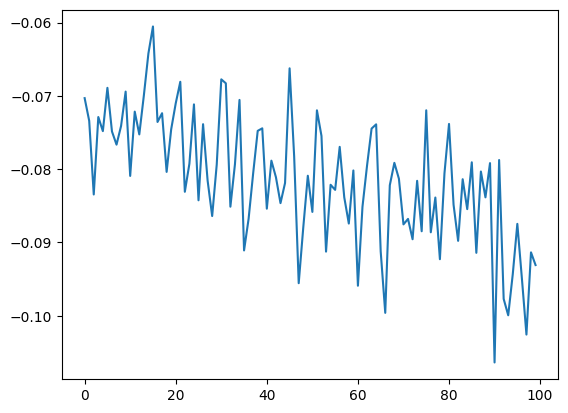

In [119]:
plt.figure()
plt.plot(PIDGIN_LOSSES)

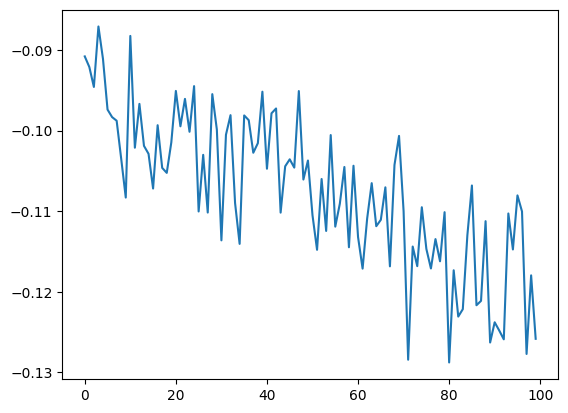

In [120]:
plt.figure()
plt.plot(HAUSA_LOSSES)

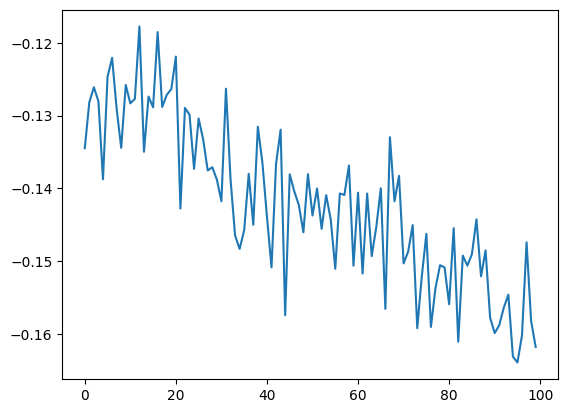

In [121]:
plt.figure()
plt.plot(IBO_LOSSES)

## Prediction

In [122]:
# Just return an output given a line
def get_output(line_tensor, rnn):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions, rnn, all_categories, n_letters, all_letters):
    print('\n> %s' % input_line)
    with torch.no_grad():
        
        input_tensor = lineToTensor(input_line, n_letters, all_letters)
        output = get_output(input_tensor, rnn)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

def predict_data(data):
  for index, row in data.iterrows():
    line = row['tweet']
    array = predict(line, 2, _RNN, all_sentiments, N_LETTERS, ALL_LETTERS)

predict_data(pidgin_t)


Streaming output truncated to the last 5000 lines.

> e never even play beta ball dis season sef injuries since
(0.21) negative
(0.18) neutral

> am not even sure of what will kill someone again corona dey outside hunger dey inside konji dey inside inside‍
(0.25) negative
(0.21) neutral

> actually got me vexed ds morning and to even imagine its from a check my status and insha allah person i don stop dat nonsense already sef sha little things like ds dey vex me sometimes
(0.27) neutral
(0.19) negative

> lmao na faith dem dey use buy cheap oga
(0.26) neutral
(0.15) negative

> lmao na dat same post wey arsenal no been fit score ddg now courtois too sigh
(0.28) neutral
(0.10) negative

> na everyone wey wear am that day dey menstruate dem for wear sanitary pad too for thong i can fit it dem too should try it
(0.22) neutral
(0.14) negative

> maybe as you like dbanj too much dey affect am this one dey pain me ooh cuz i no fit follow the gist wella now
(0.19) neutral
(0.12) positive

> n

In [123]:
predict_data(hausa_t)

Streaming output truncated to the last 5000 lines.

> duk abun da zakuyi wlh duniyar gaba daya sai kunbarta bama mulkin kadai ba marasa kishi kawai komai baku kirkiraras sai idan wani shaani na addininku yazo azzaluman ban da akayi edi dai sai munyi muga aban da zai hana mu️️️️ boss mustapha kake ko wa
(0.23) neutral
(0.16) negative

> cab muna ruwa
(0.20) neutral
(0.14) negative

> to yawale mayen jirgi ne zee saida jirgi toh a wanne zai riga fita yawo
(0.22) neutral
(0.03) negative

> shege makaryaci karya yake dan uwarsa diversional therapy
(0.29) neutral
(0.12) positive

> nan gaba in bai gyara mulkinsa bama tawaye za ai masa
(0.24) neutral
(0.18) negative

> indai ba sambisa zaa mayar dasu ba mene na basu bindiga haba azo a gyarawa mutane titi da ko makaranta ko harkar lafiya ko ilimi da kudin da zaa sayi bindiga a basu
(0.20) neutral
(0.14) negative

> innanillahi wannan wacce masifa ce
(0.22) neutral
(0.20) negative

> nima haka nagani kawai a kyale shi jaki ne
(0.20) neutral
(0

In [ ]:
predict_data(ibo_t)

Streaming output truncated to the last 5000 lines.
(0.16) negative

> ada i so ná ndị naeyi jigida
(0.28) neutral
(0.19) negative

> iti mkpu iti mkpu unu ama dị kwa na some of us bi na room with our children iti mkpu bụ iteta ụmụaka nura that is a violation of their fundamental human rights and that is punishable by law unu ga ha etigide mkpu tite jail term asịkwa na na mụ agwaghọ gị
(0.20) neutral
(0.19) negative

> ndi ikwu nnem nee kedi
(0.20) neutral
(0.16) negative

> as in iji ya
(0.26) neutral
(0.21) negative

> ma ifuro dimkpa i nu usi ego ya n ma agba gi oku
(0.17) neutral
(0.12) negative

> ọ kwa ị biala ọzọ with this ya oke sense
(0.18) negative
(0.17) neutral

> lekwa ihe ndị a dere maka gị
(0.21) neutral
(0.18) negative

> ezigbote oku my man
(0.20) neutral
(0.07) negative

> onye nkuzi lite
(0.22) negative
(0.18) neutral

> hahahaha e kwụsịkwala ịhea ike tupu ụmụaka bido kpachibe ibonge
(0.19) neutral
(0.17) negative

> nwanne tule nu ihe a eziokwu eziokwu o nwere ka o d

## Assignment

Perform an evaluation of the model
*   Provide accuracy of the model
*   Provide a confusion matrix
*   Anything else which might be helpful

Write a report on how you went about the evaluation. Be sure to explain your reasoning where necessary.

